In [131]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
from math import log2, floor, ceil
from statistics import mean, median

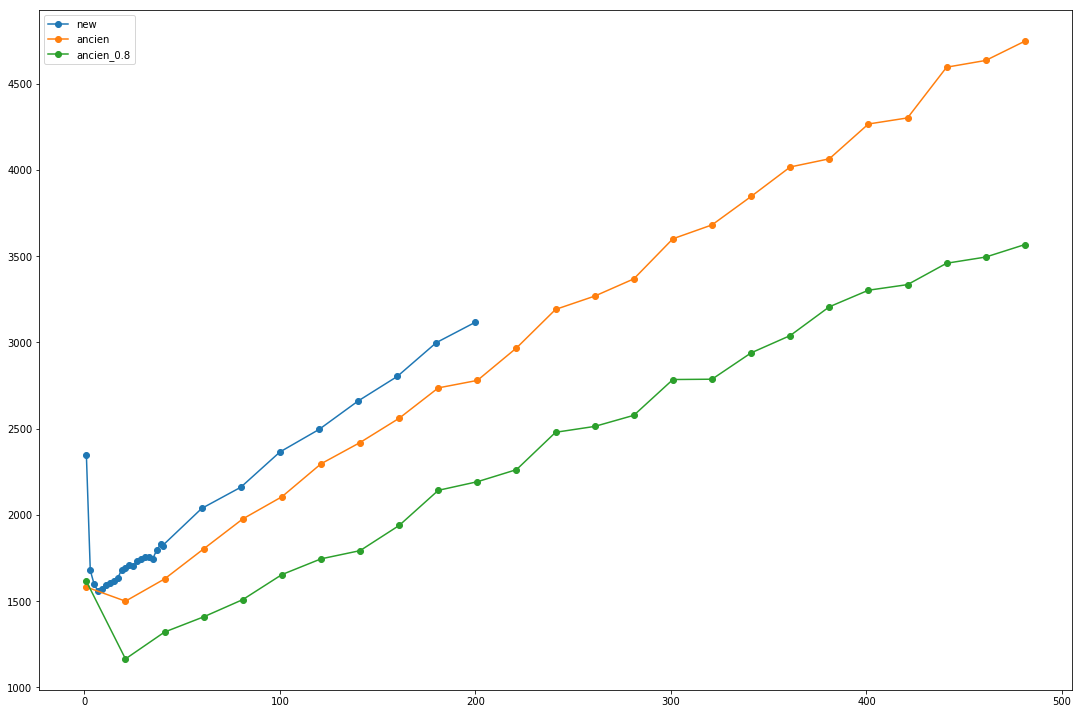

In [234]:
def load_file(filename):
    a = np.loadtxt(filename, dtype='str', comments='#')
    rsp = [round(float(x),6) for x in  a[:,0]]
    latencies = a[:,1]
    times = a[:,2]
    processors = a[:,3]
    work = a[:,4]
    i_steals = a[:,16]
    e_steals = a[:,17]
    return rsp, latencies, times, processors, work#, i_steals, i_steals

directory = "/home/khatiri/these/projet/ws-simulator/Simulation/static/"
#/home/khatiri/these/projet/ws-simulator/Simulation/proba/"

In [133]:
def compute_average(values, latence):
    average = defaultdict(int)
    run_number = defaultdict(int)
    
    for i in range(len(rsp)):
        if int(latencies[i]) == latence:
            run_number[float(rsp[i])] += 1
            average[float(rsp[i])] += int(values[i])
            
    for cle in average:
        average[cle] /= run_number[cle]
    return average

def compute_overhead_for_latence(data, latence):
    rsp, latencies, times, processors, work = data
    all_average = defaultdict(list)
    average = defaultdict(int)
    run_number = defaultdict(int)
    
    for i in range(len(rsp)):
        if int(latencies[i]) == latence:
            #run_number[float(rsp[i])] += 1
            all_average[float(rsp[i])].append(float(int(times[i]) - int(work[i])/int(processors[i])))
    for cle in sorted(all_average):
        size = len(all_average[cle])
        #average[cle] = mean(all_average[cle][ceil(0.25*size):ceil(0.75*size)])
        average[cle] = mean(all_average[cle])
        #print(mean(all_average[cle]), mean(all_average[cle][ceil(0.25*size):ceil(0.75*size)]))
  #      average[cle] = median(all_average[cle])

    return all_average, average, min(average.keys(), key=lambda x : average[x])


def compute_overhead(data, latence, variable):
    rsp, latencies, times, processors, work = data
    average = defaultdict(int)
    run_number = defaultdict(int)
    average = 0
    run_number = 0
    
    for i in range(len(rsp)):
        if float(rsp[i]) == variable and float(latencies[i]) == latence:
            run_number += 1
            average += float(int(times[i]) - int(work[i])/int(processors[i]))
            
    return average/run_number

In [168]:
def plot_for_best(filename):
    best = dict()
    base_line = dict()
    data = load_file(filename)
    latencies = data[1]
    for latence in sorted(set(latencies), key=lambda x: int(x)):
        if int(latence) > 64:
            all_average, avg_overhead, minimum  = compute_overhead_for_latence(data, int(latence))
            best_avg_overhead = compute_overhead(data, int(latence), minimum)
            best[latence] = best_avg_overhead
            if minimum < 1:
                base_line[latence] = compute_overhead(data, int(latence), 0.5)
                #print(latence, minimum)
    
    return best, base_line

In [135]:
def latence_for_best_param(filename):
    data = load_file(filename)
    latencies = data[1]
    best = dict()

    for latence in sorted(set(latencies), key=lambda x: int(x)):
        all_average, overhead, minimum = compute_overhead_for_latence(data, int(latence))
        #plt.subplot(223)
        plt.plot(overhead.keys(), overhead.values())
        best[latence] = minimum
    return best

In [136]:
def best_overhead_dict(directory):
    best_value_p = defaultdict(dict)
    best_value_w = defaultdict(dict)
    best_value_l = defaultdict(dict)

    for w in (10000000,50000000,100000000,500000000):
        for p in (16, 32, 64):
            filename = directory + "vss_static_" + str(p) + "_" + str(w)
            best, _ = plot_for_best(filename)
            for latence in best.keys():
                best_value_w[(p, int(latence))][w]=best[latence]
                best_value_p[(w, int(latence))][p]=best[latence]
                best_value_l[(w, p)][int(latence)]=best[latence]

    return best_value_w, best_value_p, best_value_l

In [137]:
def best_value_dict(directory, seuil):
    best_value_p = defaultdict(dict)
    best_value_w = defaultdict(dict)
    best_value_l = defaultdict(dict)

    for w in (10000000,50000000,100000000,500000000):
        for p in (16,32,64):
            filename = directory + "vss_static_" + str(p) + "_" + str(w)
            data = load_file(filename)
            for latence in (128,256,512,1024):
                _, overhead, minimum = compute_overhead_for_latence(data, latence)
                
                overhead_min = overhead[minimum]
                interval_max = overhead[minimum]  + 2*latence/p #+ overhead[minimum]*seuil/100

                #print(minimum, overhead[minimum], interval_max)
                
                
                overhead_plage = list(filter(lambda x : overhead_min <= overhead[x] <= interval_max, overhead))
                
                #print([(x, overhead[x]) for x in overhead_plage])
                
                best_value_w[(p, int(latence))][w]= overhead_plage
                best_value_p[(w, int(latence))][p]= overhead_plage
                best_value_l[(w, p)][int(latence)]= overhead_plage

    return best_value_w, best_value_p, best_value_l



## overhead en fonction de maximum internal steal attempts
$\lambda={128,256,512}$, $p=16,32,64$, $W=10^7,5.10^7,10^8,5.10^8$

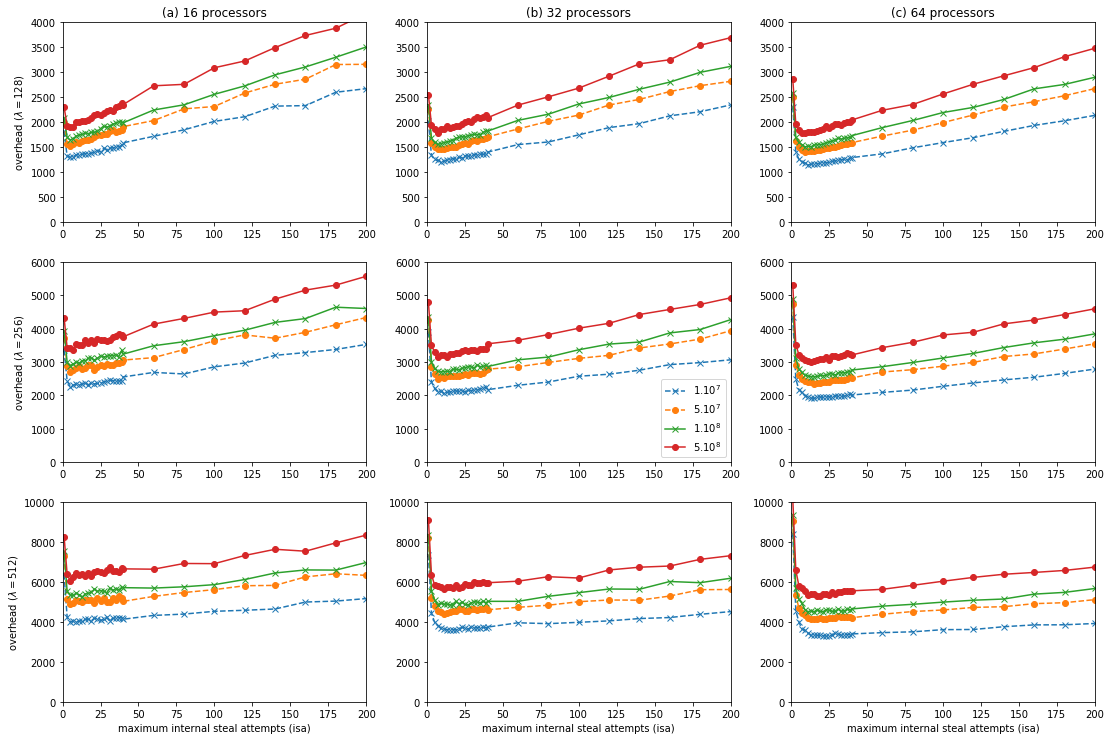

In [235]:
fig = plt.figure()
fig.set_size_inches(18.5, 12.5, forward=True)

plt.subplot(331)
#plt.xlim(0.001, 0.5)
position = 330
for (l,lim) in sorted({(128,4000),(256,6000),(512,10000)}):
    for p,c in sorted({(16,"(a)"),(32,"(b)"),(64,"(c)")}):
        #position
        position += 1
        plt.subplot(position)
        
        #labels
        if l == 512:
            plt.xlabel("maximum internal steal attempts (isa)")
        if l == 128:
            plt.title(c+" "+str(p)+" processors")
        if p == 16:
            plt.ylabel("overhead ($\lambda = "+str(l)+"$)")
        
        #limits
        plt.xlim(0, 200)
        plt.ylim(0, lim)
        
        #plots
        for w1, w2, s in sorted({(10000000,"1.$10^7$", "x--"),(50000000,"5.$10^7$", "o--"), (100000000,"1.$10^8$", "x-"), (500000000,"5.$10^8$", "o-")}):
            data = load_file(directory + "vss_static_"+str(p)+"_"+str(w1))
            #plt.title("l="+str(l)+" p="+str(p)+" w="+str(w1))
            all_average, overhead, minimum = compute_overhead_for_latence(data, l)
            plt.plot(overhead.keys(), overhead.values(), s, label=w2)
        
        #legend
        if p == 32 and l == 256: 
            plt.legend()
        plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/overhead_according_static_max_l.pdf',bbox_inches='tight')

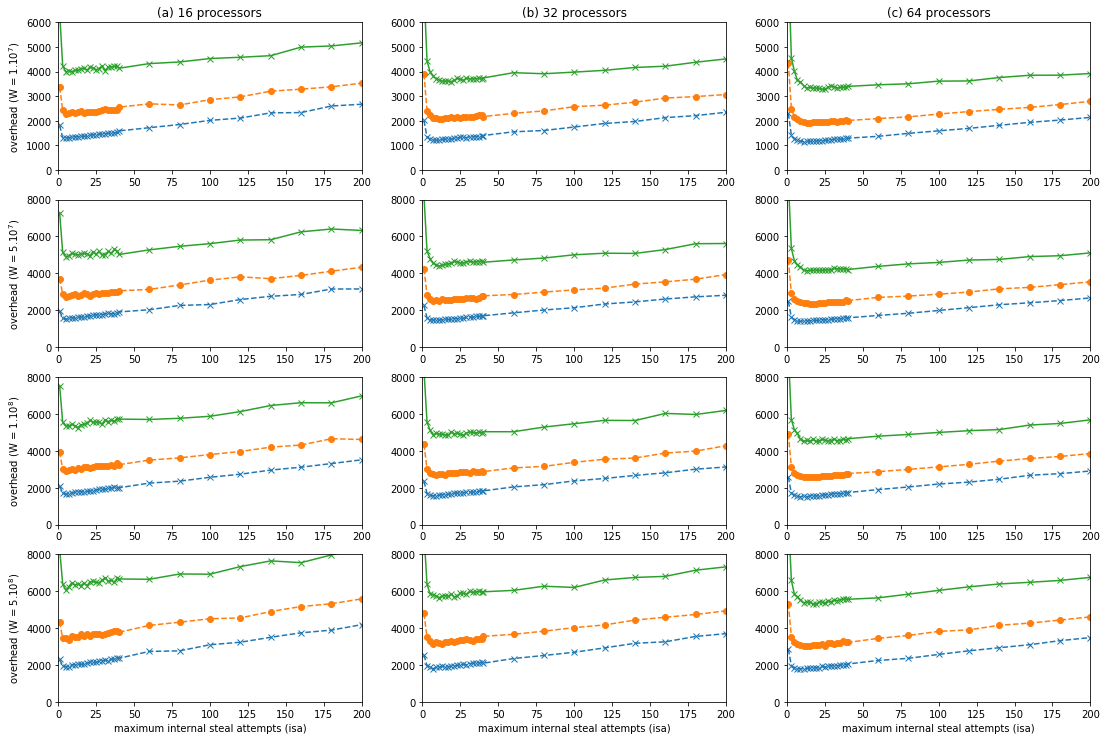

In [120]:
fig = plt.figure()
fig.set_size_inches(18.5, 12.5, forward=True)

position = 0
for w1, w2 in sorted({(10000000,"1.$10^7$"),(50000000,"5.$10^7$"), (100000000,"1.$10^8$"), (500000000,"5.$10^8$")}):
    for p,c in sorted({(16,"(a)"),(32,"(b)"),(64,"(c)")}):
        
        
    
        #position
        position += 1
        plt.subplot(4, 3, position)
        plt.ylim(0,8000)

        #plots
        data = load_file(directory + "vss_static_"+str(p)+"_"+str(w1))
        
        for l,s in sorted({(128, "x--"), (256, "o--"), (512, "x-")}):
            if w1 == 10000000:
                plt.title(c+" "+str(p)+" processors")
                plt.ylim(0,6000)

            if w1 == 500000000:
                plt.xlabel("maximum internal steal attempts (isa)")
            if p == 16:
                plt.ylabel("overhead (W = "+w2+")")
            
            plt.xlim(0, 200)
            all_average, overhead, minimum = compute_overhead_for_latence(data, l)
            plt.plot(overhead.keys(), overhead.values(), s, label=w2)
        
        #legend
        if p == 32 and l == 256: 
            plt.legend()
        plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/overhead_according_static_max_w.pdf',bbox_inches='tight')

#en fonction $W$


In [121]:
def boxdata(p, w, l, rspmin, rspmax):
    data = load_file(directory + "vss_static_{}_{}".format(p,w))
    all_average, overhead, minimum = compute_overhead_for_latence(data, l)
    #print(all_average)
    return [all_average[x] for x in all_average.keys() if rspmin <= x and x <= rspmax], \
[round(x,6) for x in all_average.keys() if rspmin <= x and x <= rspmax]


In [122]:
best_w, best_p, best_l = best_value_dict(directory, 2)


29


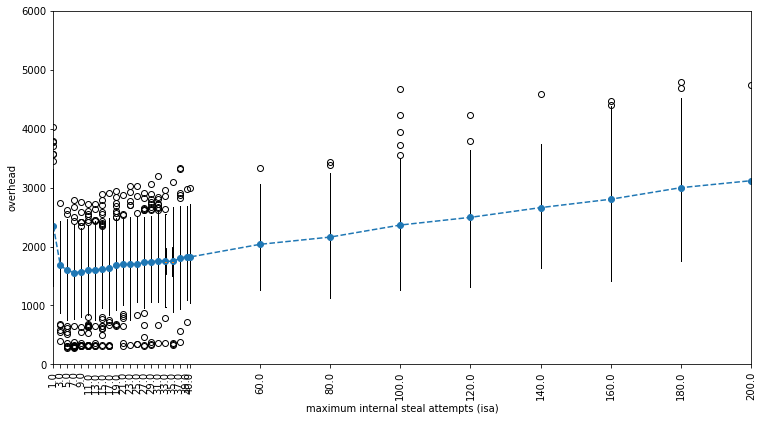

In [236]:
fig = plt.figure()
fig.set_size_inches(12.5, 6.5, forward=True)
list_avrg, list_keys = boxdata(32, 100000000, 128, 0, 200)
maxim = max(best_w[(32,128)][100000000])
#plt.subplot(111)

plt.xlabel("maximum internal steal attempts (isa)")
plt.ylabel("overhead")

data = load_file(directory + "vss_static_32_100000000")

plt.ylim(0, 6000)
plt.xticks(rotation=90)
w = [0.1]*len(list_keys)
print(len(list_keys))
keys_positions = [x*100 for x in list_keys]
plt.boxplot(list_avrg, positions=keys_positions, labels = list_keys) 
_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot([x*100 for x in overhead.keys()], overhead.values(), "o--", label="latence = 256")

plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/zoom_overhead_according_static_max_w100000000_32_256.pdf',bbox_inches='tight')


#en fonction $latence$


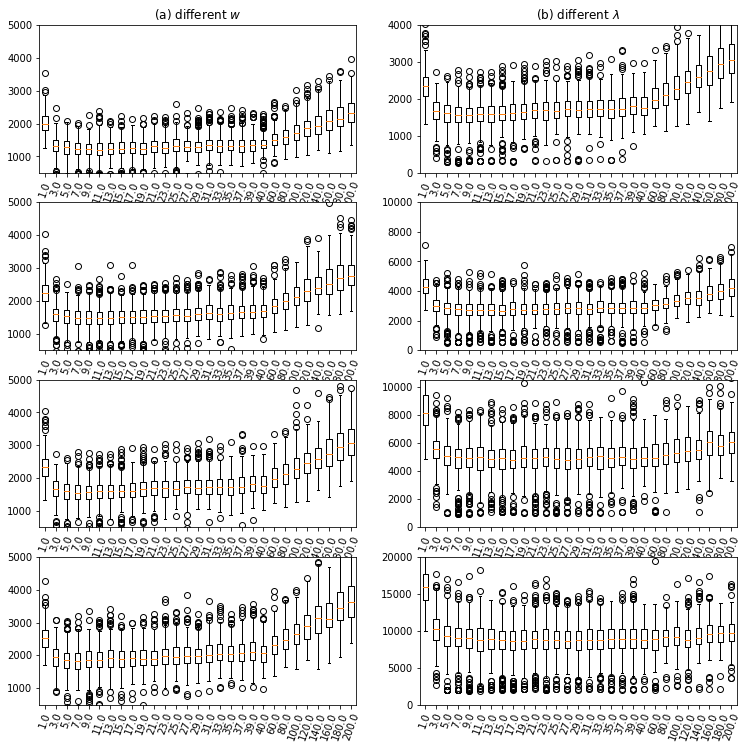

In [124]:
    
fig = plt.figure()
fig.set_size_inches(12.5, 12.5, forward=True)

list_avrg, list_keys = boxdata(32, 10000000, 128, 0, 200)
plt.subplot(421)
plt.title("(a) different $w$")
plt.ylim(500, 5000)
plt.xticks(rotation=70)
plt.plot([0.006,0.007,0.008],[5000,5000,5000])
plt.boxplot(list_avrg, labels = list_keys) #showmeans=True, 

list_avrg, list_keys = boxdata(32, 50000000, 128, 0, 200)
plt.subplot(423)
plt.ylim(500, 5000)
plt.xticks(rotation=70)
plt.boxplot(list_avrg, labels = list_keys) 

list_avrg, list_keys = boxdata(32, 100000000, 128, 0, 200)
plt.subplot(425)
plt.ylim(500, 5000)
plt.xticks(rotation=70)
plt.boxplot(list_avrg,labels = list_keys) 

list_avrg, list_keys = boxdata(32, 500000000, 128, 0, 200)
plt.subplot(427)
plt.ylim(500, 5000)
plt.xticks(rotation=70)
plt.boxplot(list_avrg, labels = list_keys) 

#----------------

list_avrg, list_keys = boxdata(32, 100000000, 128, 0, 200)
plt.subplot(422)
plt.title("(b) different $\lambda$")
plt.ylim(0, 4000)
plt.xticks(rotation=70)
plt.boxplot(list_avrg, labels = list_keys) #showmeans=True, 

list_avrg, list_keys = boxdata(32, 100000000, 256, 0, 200)
plt.subplot(424)
plt.ylim(0, 10000)
plt.xticks(rotation=70)
plt.boxplot(list_avrg, labels = list_keys) 
plt.subplot(424)

list_avrg, list_keys = boxdata(32, 100000000, 512, 0, 200)
plt.subplot(426)
plt.ylim(0, 10500)
plt.xticks(rotation=70)
plt.boxplot(list_avrg,labels = list_keys) 

list_avrg, list_keys = boxdata(32, 100000000, 1024, 0, 200)
plt.subplot(428)
plt.ylim(0, 20000)
plt.xticks(rotation=70)
plt.boxplot(list_avrg, labels = list_keys) 


plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/zoom_overhead_according_rsp_w.pdf',bbox_inches='tight')


#plt.ylim(1800, 2250)
#plt.xlim(0.01, 0.07)
#plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")


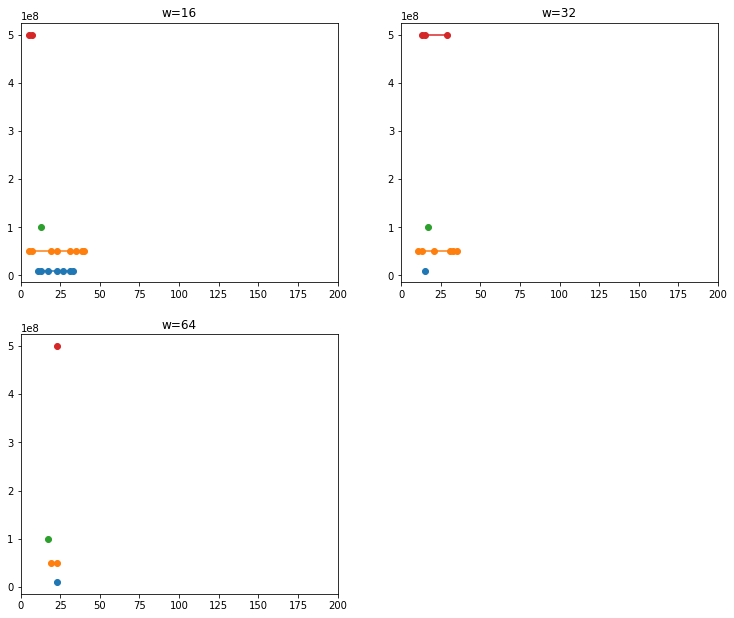

In [125]:
best_w, best_p, best_l = best_value_dict(directory, 2)

fig = plt.figure()
fig.set_size_inches(12.5, 10.5, forward=True)
plt.title("$\lambda$=124")
a = 221
for k in best_w.keys():
    if k[0] == 16 and k[1] in [1024]:
        for i in best_w[k].keys():
            plt.subplot(a)
            plt.xlim(0, 200)
            plt.title("w="+str(k[0]))
            plt.plot( best_w[k][i], [i for _ in range(len(best_w[k][i]))], "o-", label="$w$="+str(i))
            #plt.legend()

a += 1
for k in best_w.keys():
    if k[0] == 32 and k[1] in [1024]:
        for i in best_w[k].keys():
            plt.subplot(a)
            plt.xlim(0, 200)
            plt.title("w="+str(k[0]))
            plt.plot( best_w[k][i], [i for _ in range(len(best_w[k][i]))], "o-", label="$w$="+str(i))
            #plt.legend()          
a += 1
for k in best_w.keys():
    if k[0] == 64 and k[1] in [1024]:
        for i in best_w[k].keys():
            plt.subplot(a)
            plt.xlim(0,200)
            plt.title("w="+str(k[0]))
            plt.plot( best_w[k][i], [i for _ in range(len(best_w[k][i]))], "o-", label="$w$="+str(i))
            #plt.legend()          

            

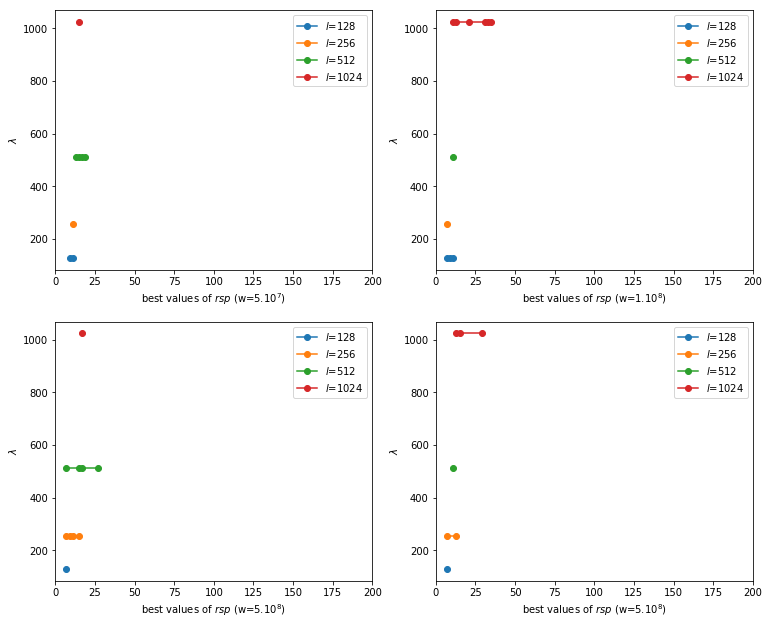

In [126]:
best_w, best_p, best_l = best_value_dict(directory, 100)
fig = plt.figure()
fig.set_size_inches(12.5, 10.5, forward=True)
a = 221
for k in best_l.keys():
    if k[0] == 10000000 and k[1] == 32:
        for i in best_l[k].keys():
            plt.ylabel("$\lambda$")
            plt.xlabel("best values of $rsp$ (w=$1.10^7$)")
            plt.subplot(a)
            plt.xlim(0, 200)
            plt.plot( best_l[k][i], [i for _ in range(len(best_l[k][i]))], "o-", label="$l$="+str(i))
            plt.legend()

a += 1
for k in best_l.keys():
    if k[0] == 50000000 and k[1] == 32:
        for i in best_l[k].keys():
            plt.ylabel("$\lambda$")
            plt.xlabel("best values of $rsp$ (w=$5.10^7$)")
            plt.subplot(a)
            plt.xlim(0, 200)
            plt.plot( best_l[k][i], [i for _ in range(len(best_l[k][i]))], "o-", label="$l$="+str(i))
            plt.legend()          
a += 1
for k in best_l.keys():
    if k[0] == 100000000 and k[1] == 32:
        for i in best_l[k].keys():
            plt.ylabel("$\lambda$")
            plt.xlabel("best values of $rsp$ (w=$1.10^8$)")
            plt.subplot(a)
            plt.xlim(0, 200)
            plt.plot( best_l[k][i], [i for _ in range(len(best_l[k][i]))], "o-", label="$l$="+str(i))
            plt.legend()          
a += 1
for k in best_l.keys():
    if k[0] == 500000000 and k[1] == 32:
        for i in best_l[k].keys():
            plt.ylabel("$\lambda$")
            plt.xlabel("best values of $rsp$ (w=$5.10^8$)")
            plt.subplot(a)
            plt.xlim(0, 200)
            #a += 2
            plt.plot( best_l[k][i], [i for _ in range(len(best_l[k][i]))], "o-", label="$l$="+str(i))
            plt.legend()          


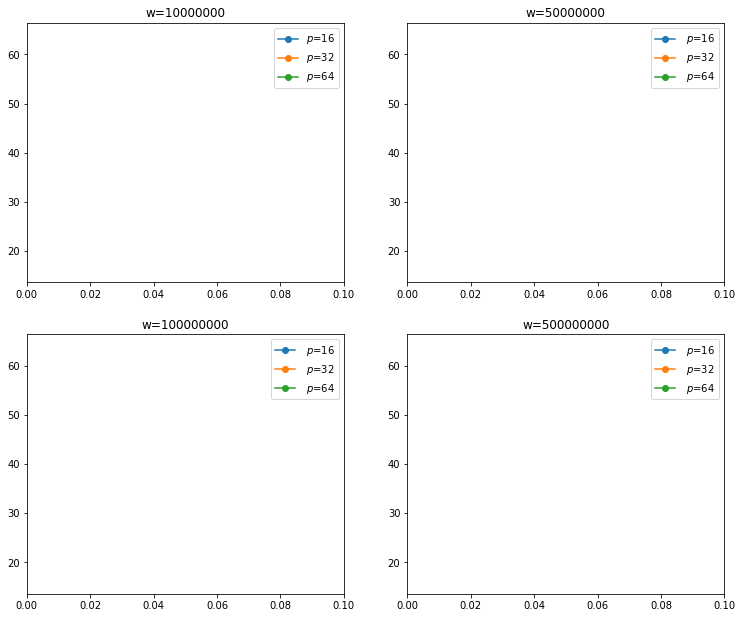

In [127]:
best_w, best_p, best_l = best_value_dict(directory, 5)
fig = plt.figure()
fig.set_size_inches(12.5, 10.5, forward=True)
plt.title("$\lambda$=124")
a = 221
for k in best_p.keys():
    if k[0] == 10000000 and k[1] == 1024:
        for i in best_p[k].keys():
            plt.subplot(a)
            plt.xlim(0, 0.1)
            plt.title("w="+str(k[0]))
            plt.plot( best_p[k][i], [i for _ in range(len(best_p[k][i]))], "o-", label="$p$="+str(i))
            plt.legend()

a += 1
for k in best_p.keys():
    if k[0] == 50000000 and k[1] == 1024:
        for i in best_p[k].keys():
            plt.subplot(a)
            plt.xlim(0, 0.1)
            plt.title("w="+str(k[0]))
            plt.plot( best_p[k][i], [i for _ in range(len(best_p[k][i]))], "o-", label=" $p$="+str(i))
            plt.legend()          
a += 1
for k in best_p.keys():
    if k[0] == 100000000 and k[1] == 1024:
        for i in best_p[k].keys():
            plt.subplot(a)
            plt.xlim(0, 0.1)
            plt.title("w="+str(k[0]))
            plt.plot( best_p[k][i], [i for _ in range(len(best_p[k][i]))], "o-", label=" $p$="+str(i))
            plt.legend()          
a += 1
for k in best_p.keys():
    if k[0] == 500000000 and k[1] == 1024:
        for i in best_p[k].keys():
            plt.subplot(a)
            plt.xlim(0, 0.1)
            plt.title("w="+str(k[0]))
            #a += 2
            plt.plot( best_p[k][i], [i for _ in range(len(best_p[k][i]))], "o-", label=" $p$="+str(i))
            plt.legend()          

#en fonction $Proc\_number$


# A faire :

tourner des simulations entre avec max_internal_steal entre {0 40} pour savoir une courbe bien precis

Afficher l'interface de confiance

{'8': 185.005, '16': 289.9875, '32': 452.7225, '64': 764.675, '128': 1355.35, '256': 2364.86, '512': 4313.65, '1024': 7737.5975}


ValueError: x and y must have same first dimension, but have shapes (8,) and (5,)

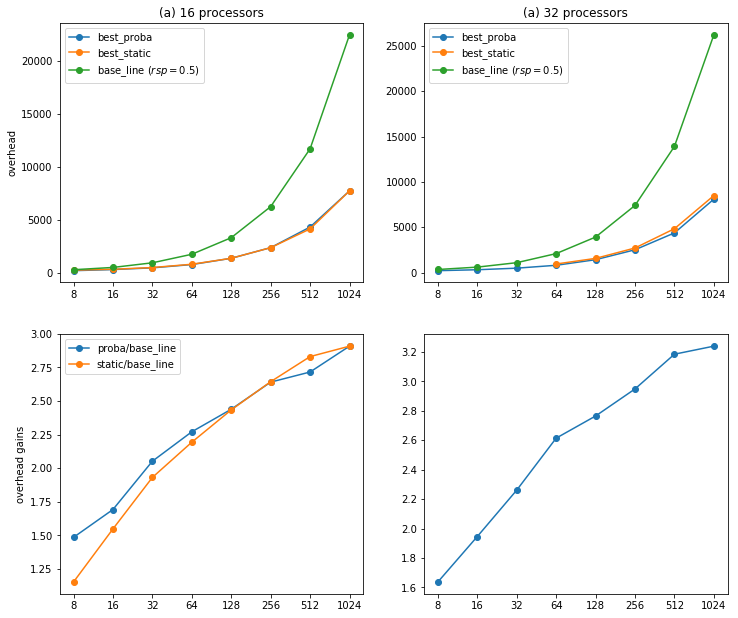

In [166]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"
filename = "/home/khatiri/these/projet/ws-simulator/Simulation/proba/" + "vss_proba_16_100000000"
best_proba, base_line = plot_for_best(filename)
print(best_proba)
filename = "/home/khatiri/these/projet/ws-simulator/Simulation/" + "vss_static_16_100000000"
best_static, _ = plot_for_best(filename)

plt.subplot(231)
plt.title("(a) 16 processors")
plt.ylabel("overhead")

plt.plot(best_proba.keys(), best_proba.values(), 'o-', label="best_proba")
plt.plot(best_static.keys(), best_static.values(), 'o-', label="best_static")
plt.plot(base_line.keys(), base_line.values(), 'o-', label="base_line ($rsp=0.5$)")

plt.legend()

plt.subplot(234)
plt.ylabel("overhead gains")

plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_proba.values(), base_line.values())], 'o-', label="proba/base_line")
plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_static.values(), base_line.values())], 'o-', label="static/base_line")
plt.legend()

#---- 32 proc

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"

filename = "/home/khatiri/these/projet/ws-simulator/Simulation/proba/" + "vss_proba_32_100000000"
best_proba, base_line = plot_for_best(filename)

filename = directory + "vss_static_32_100000000"
best_static, _ = plot_for_best(filename)

plt.subplot(232)
plt.title("(a) 32 processors")

plt.plot(best_proba.keys(), best_proba.values(), 'o-', label="best_proba")
plt.plot(best_static.keys(), best_static.values(), 'o-', label="best_static")
plt.plot(base_line.keys(), base_line.values(), 'o-', label="base_line ($rsp=0.5$)")

plt.legend()

plt.subplot(235)
plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_proba.values(), base_line.values())], 'o-', label="proba/base_line")
plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_static.values(), base_line.values())], 'o-', label="static/base_line")


#---- 64 proc

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"

filename = "/home/khatiri/these/projet/ws-simulator/Simulation/proba/" + "vss_proba_64_500000000"
print("---------- proba ----------")
best_proba, base_line = plot_for_best(filename)
print("---------- static ----------")
filename = directory + "vss_static_64_500000000"
best_static, _ = plot_for_best(filename)

print("static", best_static)
print("proba", best_proba)
print("base_line", base_line)

"""
plt.subplot(233)
plt.title("(a) 64 processors")

plt.plot(best_proba.keys(), best_proba.values(), 'o-', label="best_proba")
plt.plot(best_static.keys(), best_static.values(), 'o-', label="best_static")
plt.plot(base_line.keys(), base_line.values(), 'o-', label="base_line ($rsp=0.5$)")

plt.legend()

plt.subplot(236)
#plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_proba.values(), base_line.values())], 'o-', label="proba/base_line")
#plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_static.values(), base_line.values())], 'o-', label="static/base_line")
"""
plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/proba_vs_static_for_best_config.pdf',bbox_inches='tight')

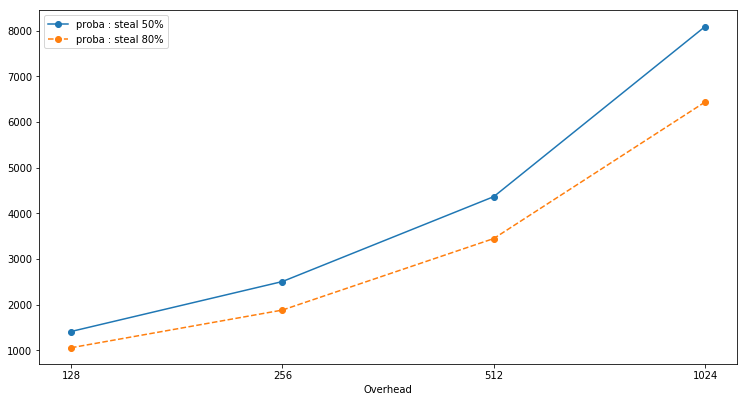

In [251]:
fig = plt.figure()
fig.set_size_inches(12.5, 6.5, forward=True)

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"
directory_p = "/home/khatiri/these/projet/ws-simulator/Simulation/proba/"
directory_s = "/home/khatiri/these/projet/ws-simulator/Simulation/simulation/simulation/"

filename = directory_p + "vss_proba_32_100000000"
best_proba_50, _ = plot_for_best(filename)

filename = directory_p + "vss_proba_32_100000000_0.8"
best_proba_80, _ = plot_for_best(filename)
plt.xlabel("remote steal probability (rsp)")
plt.xlabel("Overhead")

plt.plot(best_proba_50.keys(), best_proba_50.values(), 'o-', label="proba : steal 50%")
plt.plot(best_proba_80.keys(), best_proba_80.values(), 'o--', label="proba : steal 80%")
plt.legend()



plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/proba_05_vs_08_32_100000000.pdf',bbox_inches='tight')
plt.legend()


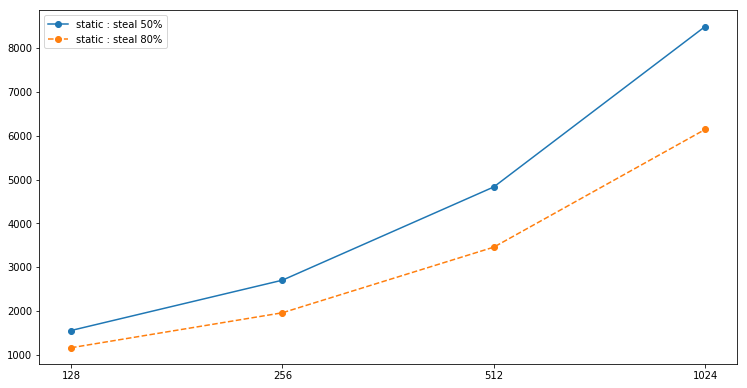

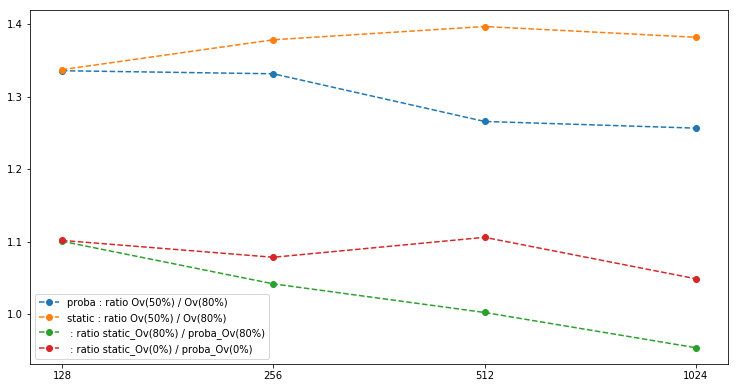

In [249]:

fig = plt.figure()
fig.set_size_inches(12.5, 6.5, forward=True)

filename = directory + "vss_static_32_100000000"
best_static_50, _ = plot_for_best(filename)
plt.plot(best_static_50.keys(), best_static_50.values(), 'o-', label="static : steal 50%")

filename = directory_s + "vss_static_32_100000000_0.8"
best_static_80, _ = plot_for_best(filename)
plt.plot(best_static_80.keys(), best_static_80.values(), 'o--', label="static : steal 80%")
plt.legend()

plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/static_05_vs_08_32_100000000.pdf',bbox_inches='tight')

fig = plt.figure()
fig.set_size_inches(12.5, 6.5, forward=True)

plt.plot(best_proba_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_proba_50.values(), best_proba_80.values())],\
         'o--', label="proba : ratio Ov(50%) / Ov(80%)")

plt.plot(best_static_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_static_50.values(), best_static_80.values())],\
         'o--', label="static : ratio Ov(50%) / Ov(80%)")

plt.legend()

plt.plot(best_proba_80.keys(), [bs8/bp8 for (bp8, bs8) in zip(best_proba_80.values(), best_static_80.values())],\
         'o--', label=" : ratio static_Ov(80%) / proba_Ov(80%)")

plt.plot(best_proba_80.keys(), [bs5/bp5 for (bp5, bs5) in zip(best_proba_50.values(), best_static_50.values())],\
         'o--', label=" : ratio static_Ov(0%) / proba_Ov(0%)")

plt.legend()

# a faire : 

- Separer les courbes, les decrires,

- afficher les intervals de confiance

- mettre a jour les courbes avec les nouveaux dimulation


## amount of work steal (80% vs 50%)
we plot the overhead according to the latency for best parametre "$rsp$" or "$max\ internal\ steal$" 

In [68]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"
filename = directory + "vss_proba_32_10000000"
best_proba_50 = plot_for_best(filename)

filename = directory + "vss_proba_32_10000000_0.8"
best_proba_80 = plot_for_best(filename)

plt.subplot(321)
plt.plot(best_proba_50.keys(), best_proba_50.values(), 'o-', label="proba : steal 50%")
plt.plot(best_proba_80.keys(), best_proba_80.values(), 'o--', label="proba : steal 80%")
plt.legend()


plt.legend()


#************************************ 

filename = directory + "vss_static_32_10000000"
best_static_50 = plot_for_best(filename)
plt.subplot(322)
plt.plot(best_static_50.keys(), best_static_50.values(), 'o-', label="static : steal 50%")

filename = directory + "vss_static_32_10000000_0.8"
best_static_80 = plot_for_best(filename)
plt.plot(best_static_80.keys(), best_static_80.values(), 'o--', label="static : steal 80%")
plt.legend()

plt.subplot(312)

plt.plot(best_proba_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_proba_50.values(), best_proba_80.values())],\
         'o--', label="proba : ratio Ov(50%) / Ov(80%)")

plt.plot(best_static_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_static_50.values(), best_static_80.values())],\
         'o--', label="static : ratio Ov(50%) / Ov(80%)")

plt.legend()
plt.subplot(313)

plt.plot(best_proba_80.keys(), [bs8/bp8 for (bp8, bs8) in zip(best_proba_80.values(), best_static_80.values())],\
         'o--', label=" : ratio static_Ov(80%) / proba_Ov(80%)")

plt.plot(best_proba_50.keys(), [bs5/bp5 for (bp5, bs5) in zip(best_proba_50.values(), best_static_50.values())],\
         'o--', label=" : ratio static_Ov(50%) / proba_Ov(50%)")

plt.legend()

OSError: /home/khatiri/these/projet/ws-simulator/src/resultat_finition/static/vss_proba_32_10000000 not found.

<Figure size 1332x756 with 0 Axes>

In [69]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"
filename = directory + "vss_proba_16_100000000"
best_proba_50 = plot_for_best(filename)

filename = directory + "vss_proba_16_100000000_0.8"
best_proba_80 = plot_for_best(filename)

plt.subplot(321)
plt.plot(best_proba_50.keys(), best_proba_50.values(), 'o-', label="proba : steal 50%")
plt.plot(best_proba_80.keys(), best_proba_80.values(), 'o--', label="proba : steal 80%")
plt.legend()


plt.legend()


#************************************ 

filename = directory + "vss_static_16_100000000"
best_static_50 = plot_for_best(filename)
plt.subplot(322)
plt.plot(best_static_50.keys(), best_static_50.values(), 'o-', label="static : steal 50%")

filename = directory + "vss_static_16_100000000_0.8"
best_static_80 = plot_for_best(filename)
plt.plot(best_static_80.keys(), best_static_80.values(), 'o--', label="static : steal 80%")
plt.legend()

plt.subplot(312)

plt.plot(best_proba_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_proba_50.values(), best_proba_80.values())],\
         'o--', label="proba : ratio Ov(50%) / Ov(80%)")

plt.plot(best_static_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_static_50.values(), best_static_80.values())],\
         'o--', label="static : ratio Ov(50%) / Ov(80%)")

plt.legend()
plt.subplot(313)

plt.plot(best_proba_80.keys(), [bs8/bp8 for (bp8, bs8) in zip(best_proba_80.values(), best_static_80.values())],\
         'o--', label=" : ratio static_Ov(80%) / proba_Ov(80%)")

plt.plot(best_proba_50.keys(), [bs5/bp5 for (bp5, bs5) in zip(best_proba_50.values(), best_static_50.values())],\
         'o--', label=" : ratio static_Ov(50%) / proba_Ov(50%)")

plt.legend()

OSError: /home/khatiri/these/projet/ws-simulator/src/resultat_finition/static/vss_proba_16_100000000 not found.

<Figure size 1332x756 with 0 Axes>

In [70]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"
filename = directory + "vss_proba_16_10000000"
best_proba_50 = plot_for_best(filename)

filename = directory + "vss_proba_16_10000000_0.8"
best_proba_80 = plot_for_best(filename)

plt.subplot(321)
plt.plot(best_proba_50.keys(), best_proba_50.values(), 'o-', label="proba : steal 50%")
plt.plot(best_proba_80.keys(), best_proba_80.values(), 'o--', label="proba : steal 80%")
plt.legend()


plt.legend()


#************************************ 

filename = directory + "vss_static_16_10000000"
best_static_50 = plot_for_best(filename)
plt.subplot(322)
plt.plot(best_static_50.keys(), best_static_50.values(), 'o-', label="static : steal 50%")

filename = directory + "vss_static_16_10000000_0.8"
best_static_80 = plot_for_best(filename)
plt.plot(best_static_80.keys(), best_static_80.values(), 'o--', label="static : steal 80%")
plt.legend()

plt.subplot(312)

plt.plot(best_proba_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_proba_50.values(), best_proba_80.values())],\
         'o--', label="proba : ratio Ov(50%) / Ov(80%)")

plt.plot(best_static_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_static_50.values(), best_static_80.values())],\
         'o--', label="static : ratio Ov(50%) / Ov(80%)")

plt.legend()
plt.subplot(313)

plt.plot(best_proba_80.keys(), [bs8/bp8 for (bp8, bs8) in zip(best_proba_80.values(), best_static_80.values())],\
         'o--', label=" : ratio static_Ov(80%) / proba_Ov(80%)")

plt.plot(best_proba_50.keys(), [bs5/bp5 for (bp5, bs5) in zip(best_proba_50.values(), best_static_50.values())],\
         'o--', label=" : ratio static_Ov(50%) / proba_Ov(50%)")

plt.legend()

OSError: /home/khatiri/these/projet/ws-simulator/src/resultat_finition/static/vss_proba_16_10000000 not found.

<Figure size 1332x756 with 0 Axes>

# A faire :

- tourner plus de resultats pour clarifier les choses
- tourner des resultats pour les autres strategies